In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_columns = 999

In [14]:
# Cargar datos

import glob
path =r'./microdatos' # use your path
allFiles = glob.glob(path + "/usu_individual*.txt")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0, delimiter = ';')
    list_.append(df)
datos = pd.concat(list_)

usd_ars = pd.read_csv('./usd_ars.csv')
usd_ars = usd_ars.groupby(['ANO4', 'TRIMESTRE'])[['USD/ARS']].mean().reset_index()
datos = datos.merge(usd_ars)
datos['ingreso_usd'] = datos['P47T'] / datos['USD/ARS']

In [66]:
sample_size = datos.groupby(['ANO4', 'TRIMESTRE']).count()['CODUSU'].mean()
total_pob = 4.4e7


In [126]:
#Selecciona mayores de 18
ingreso = 'ingreso_usd'
datos_mayores = datos.loc[datos.CH06 >= 18]
# datos_mayores['P47T'] = datos_mayores[['P47T']].div(datos_mayores.groupby(['ANO4', 'TRIMESTRE'])[['P47T']].transform('median'))

datos_mayores['bin_ingreso'] = pd.cut(np.log10(datos_mayores[ingreso].clip(0.01, np.inf)), 40)


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [127]:
bootstrap_list = []

for i in range(2):

    sample = datos_mayores.groupby(['ANO4', 'TRIMESTRE']).apply(lambda x: x.sample(frac = .05)).reset_index(drop = True)
    
    sample_i = sample.groupby(['ANO4', 'TRIMESTRE','bin_ingreso'])[ingreso].agg(['count', 'sum', 'mean', 'median'])
    sample_i['PDF'] = sample_i.groupby(['ANO4', 'TRIMESTRE'])['count'].apply(lambda x: x/x.sum())
    sample_i['CDF'] = sample_i.groupby(['ANO4', 'TRIMESTRE'])['count'].apply(lambda x: x.cumsum()/x.sum())

    sample_i.columns = pd.MultiIndex.from_product([['sample_'+str(i)], sample_i.columns])

    bootstrap_list += [sample_i]

bootstrap = pd.concat(bootstrap_list, axis = 1)

In [128]:
bootstrap.columns = bootstrap.columns.swaplevel()
mean_ = bootstrap.groupby(axis = 1, level = 0).mean(); mean_.columns = pd.MultiIndex.from_product([mean_.columns, ['value']])
std_ = bootstrap.groupby(axis = 1, level = 0).std(); std_.columns = pd.MultiIndex.from_product([std_.columns, ['std']])


In [129]:
result_pdf = pd.concat([mean_, std_], axis = 1).sort_index(axis = 1)


In [36]:
result_pdf.head(10)

CDF                 PDF            \
                                      std     value       std     value   
ANO4 TRIMESTRE bin_ingreso                                                
2016 2         (-2.007, -1.866]  0.002084  0.330776  0.002084  0.330776   
               (0.413, 0.547]         NaN  0.332714       NaN  0.000465   
               (0.949, 1.083]         NaN  0.329767       NaN  0.000465   
               (1.217, 1.351]    0.001096  0.332403  0.000987  0.001163   
               (1.351, 1.485]    0.001425  0.333100  0.000328  0.000697   
               (1.485, 1.619]    0.001753  0.334263  0.000328  0.001162   
               (1.619, 1.753]    0.004044  0.348906  0.002292  0.014644   
               (1.753, 1.887]    0.004697  0.355879  0.000653  0.006973   
               (1.887, 2.022]    0.006007  0.362853  0.001310  0.006973   
               (2.022, 2.156]    0.000728  0.392143  0.005279  0.029290   

                                     count             mean              \
                                       std  value       std       value   
ANO4 TRIMESTRE bin_ingreso                                                
2016 2         (-2.007, -1.866]   4.949747  711.5  0.003036   -0.255428   
               (0.413, 0.547]          NaN    1.0       NaN    3.517797   
               (0.949, 1.083]          NaN    1.0       NaN   10.553392   
               (1.217, 1.351]     2.121320    2.5  0.920360   20.455992   
               (1.351, 1.485]     0.707107    1.5  0.000000   28.142379   
               (1.485, 1.619]     0.707107    2.5  0.000000   35.177974   
               (1.619, 1.753]     4.949747   31.5  0.314841   51.105053   
               (1.753, 1.887]     1.414214   15.0  0.783549   66.319276   
               (1.887, 2.022]     2.828427   15.0  1.186326   90.190913   
               (2.022, 2.156]    11.313708   63.0  1.032502  126.321853   

                                   median                      sum  \
                                      std       value          std   
ANO4 TRIMESTRE bin_ingreso                                           
2016 2         (-2.007, -1.866]  0.000000    0.000000     0.895485   
               (0.413, 0.547]         NaN    3.517797          NaN   
               (0.949, 1.083]         NaN   10.553392          NaN   
               (1.217, 1.351]    0.596990   20.684649    41.092813   
               (1.351, 1.485]    0.000000   28.142379    19.899667   
               (1.485, 1.619]    0.000000   35.177974    24.874584   
               (1.619, 1.753]    0.000000   50.656283   262.874604   
               (1.753, 1.887]    3.333194   67.999024    82.036378   
               (1.887, 2.022]    4.974917   87.944935   237.303531   
               (2.022, 2.156]    0.000000  133.676301  1494.216261   

                                              
                                       value  
ANO4 TRIMESTRE bin_ingreso                    
2016 2         (-2.007, -1.866]  -181.729414  
               (0.413, 0.547]       3.517797  
               (0.949, 1.083]      10.553392  
               (1.217, 1.351]      50.163791  
               (1.351, 1.485]      42.213569  
               (1.485, 1.619]      87.944935  
               (1.619, 1.753]    1610.588364  
               (1.753, 1.887]     994.235081  
               (1.887, 2.022]    1351.185983  
               (2.022, 2.156]    7964.117435

### Value distribution

In [108]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: RuntimeWarning: invalid value encountered in log10
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: RuntimeWarning: invalid value encountered in log10
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: RuntimeWarning: invalid value encountered in log10


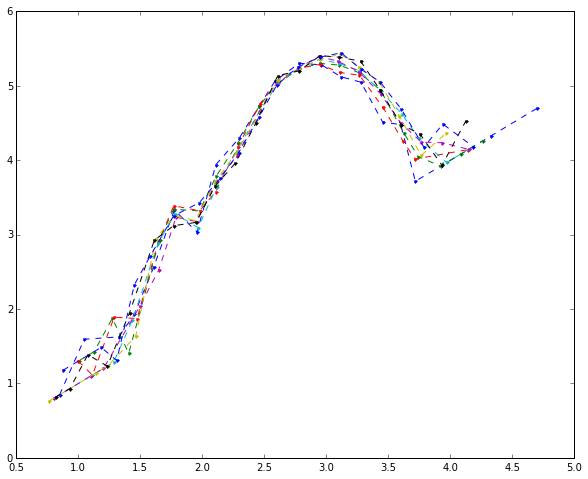

In [130]:
nrows = 2
n = 8
ncols = n/nrows
# fig, axs = plt.subplots(nrows, ncols, figsize = (10 * ncols, 8 * nrows))
fig, axs = plt.subplots(1, figsize = (10, 8 ))

for i in range(n):
    ax= axs
#     ax = axs[(np.arange(n)/4)[i]][(np.arange(n)%4)[i]]
#     ax.locator_params(nbins=4)
    tp = time_periods[i]
    data = result_pdf.loc[tp]
    
    x = np.log10(data[('mean', 'value')].values)
    y = np.log10(data[('sum', 'value')].values)
    yerr = np.log10(1 - data[('sum', 'value')].values) - np.log10(1 - data[('sum', 'value')].values - data[('sum', 'std')].values/2.)
    
    ax.errorbar(x, y, yerr=yerr, fmt='--.')

plt.show()


## Linear fit of the (Pareto) right tail

Pareto alpha: 2.23231698963
Xm: 300.0
Xm_err: 20.0


/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log10
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: RuntimeWarning: invalid value encountered in subtract
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:14: RuntimeWarning: invalid value encountered in greater


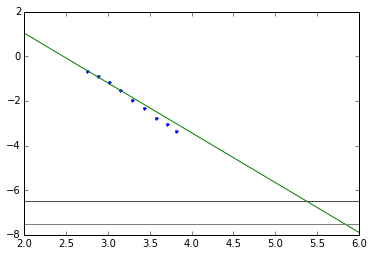

Pareto alpha: 1.46673341715
Xm: 200.0
Xm_err: 320.0


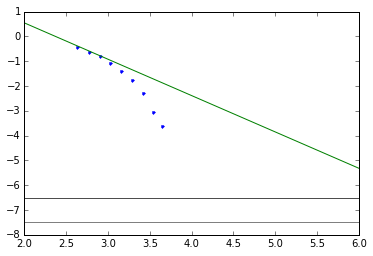

Pareto alpha: 1.70886293989
Xm: 200.0
Xm_err: 30.0


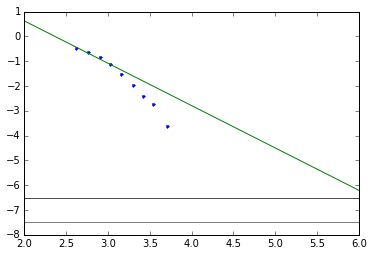

Pareto alpha: 1.87573249773
Xm: 300.0
Xm_err: 180.0


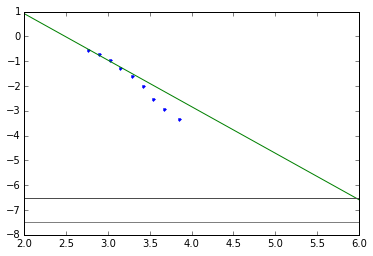

Pareto alpha: 2.55795880202
Xm: 400.0
Xm_err: 10.0


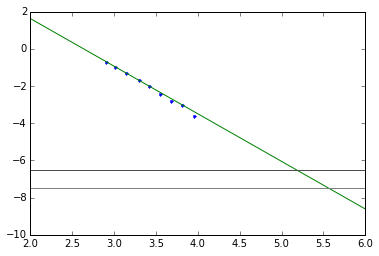

Pareto alpha: 2.10674936106
Xm: 400.0
Xm_err: 130.0


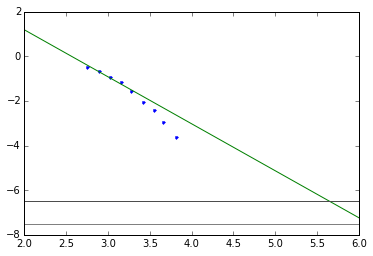

Pareto alpha: 2.60381054768
Xm: 400.0
Xm_err: 80.0


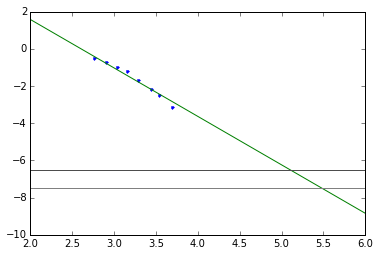

Pareto alpha: 3.17100227636
Xm: 600.0
Xm_err: 10.0


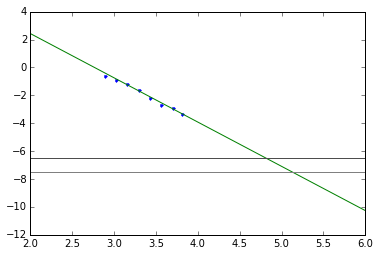

In [99]:
data_ = data
alpha = []
xm_a = []

for i in range(nrows):
    ax = axs[i,0]
#     ax.locator_params(nbins=4)
    tp = time_periods[i]
    data = result_pdf.loc[tp].iloc[-10:]
    
    x = np.log10(data[('mean', 'value')].values)
    y = np.log10(1 - data[('CDF', 'value')].values)
    yerr = np.log10(1 - data[('CDF', 'value')].values) - np.log10(1 - data[('CDF', 'value')].values - data[('CDF', 'std')].values/2.)
    valid_mask = (y > -np.inf) & (yerr > -np.inf)
    z = np.polyfit(x[valid_mask], y[valid_mask], 1, w = 1/yerr[valid_mask], full = False, cov = True)
    alpha += [-z[0][0]]
    xm_a += [np.power(10, z[0][1])]
    print 'Pareto alpha: '+str(-z[0][0])
    xm = np.power(10, -z[0][1]/z[0][0])
    xm_err = np.power(10, -(z[0][1] + z[1][1, 1])/z[0][0]) - xm
    print 'Xm: '+str(round(xm, -2))
    print 'Xm_err: '+str(round(xm_err, -1))
    xp = np.linspace(2, 6, 10)
    p = np.poly1d(z[0])

    _ = plt.plot(x, y, '.', xp, p(xp), '-')
    plt.axhline(-7.5, c = '.5')
    plt.axhline(-6.5, '-', c = '.3')
#     plt.xlim(4,6)
#     plt.ylim(-5,0)
    plt.show()


## Plot using info from right tail Pareto fits

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: RuntimeWarning: invalid value encountered in log10
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:39: RuntimeWarning: divide by zero encountered in log10
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:41: RuntimeWarning: divide by zero encountered in log10
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:41: RuntimeWarning: invalid value encountered in subtract


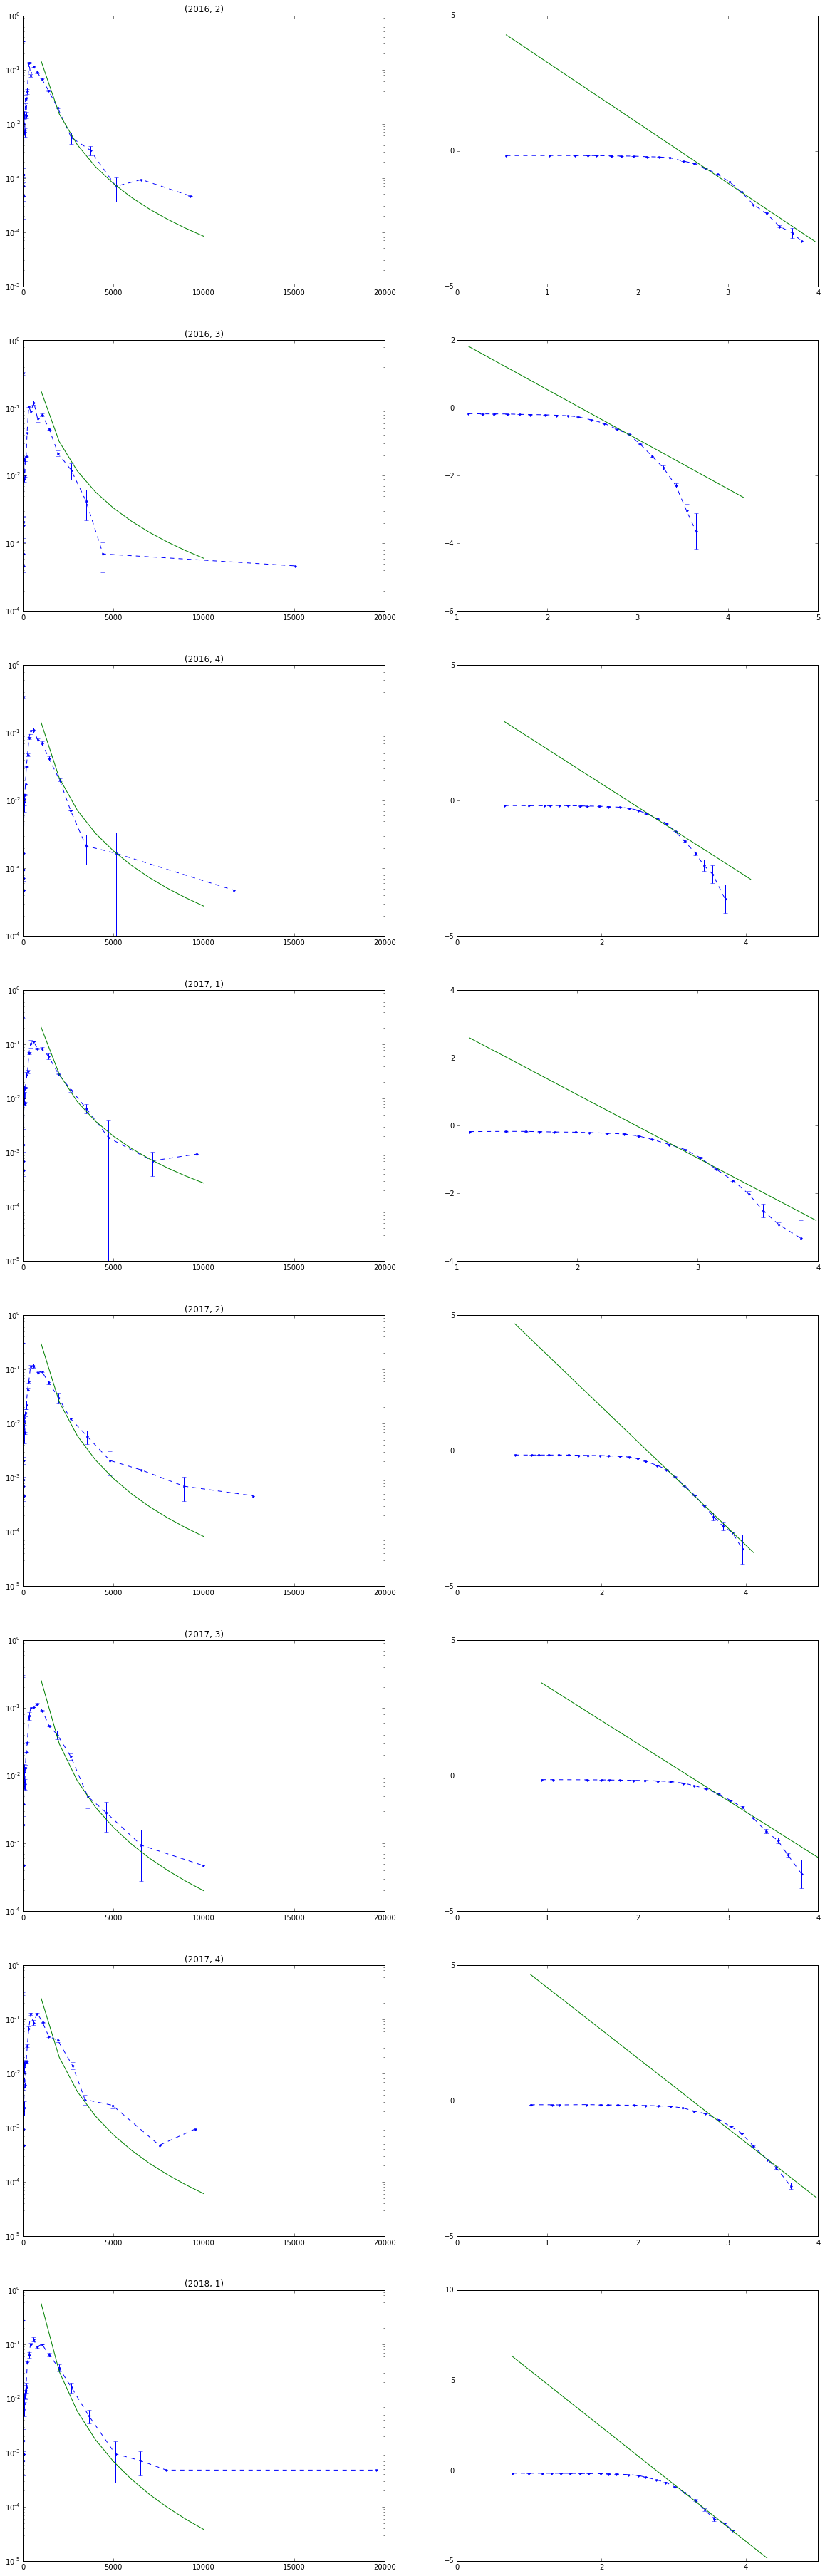

In [97]:
# Now switch to a more OO interface to exercise more features.
time_periods = [(2016, 2),(2016, 3),(2016, 4), (2017, 1), (2017, 2), (2017, 3), (2017, 4), (2018, 1)]

nrows=len(time_periods)
ncols=2
fig, axs = plt.subplots(nrows, ncols, figsize = (10 * ncols, 8 * nrows))
 # With 4 subplots, reduce the number of axis ticks to avoid crowding.

#Pareto params
# xm = 8/3.; alpha = 3.;

for i in range(nrows):
    ax = axs[i,0]
    ax.locator_params(nbins=4)
    tp = time_periods[i]
    data = result_pdf.loc[tp]
    x = data[('mean', 'value')].values
    y = data[('PDF', 'value')].values
    yerr = data[('PDF', 'std')].values
    ax.errorbar(x, y, yerr=yerr, fmt='--.')
    
    xp = np.linspace(1000, 10000, 10)
    ax.plot(xp, 1e3 * alpha[i]*xm_a[i]/np.power(xp, alpha[i]+1), '-')
    
    ax.set_title(str(tp))
    ax.set_yscale('log')
#     ax.set_xscale('log')
    ax.set_xlim(0, 20000)
#     ax.set_ylim(0, .2)
    
#     x_ = np.array([_ for _ in x if _ > np.power(10, xm)])
#     y_pareto = 2000000 * alpha * np.power(1000,alpha)/ np.power(x_, (alpha + 1))
#     ax.plot(x_, y_pareto)

    ax = axs[i,1]
    ax.locator_params(nbins=4)
    x_ = np.log10(data[('mean', 'value')].values)
    y_ = np.log10(1 - data[('CDF', 'value')].values)
    y_pareto = np.log10(xm_a[i]) - alpha[i]*x_
    yerr = np.log10(1 - data[('CDF', 'value')].values) - np.log10(1 - data[('CDF', 'value')].values - data[('CDF', 'std')].values/2.)
    ax.errorbar(x_, y_, yerr, fmt='--.')
    ax.plot(x_, y_pareto)
#     ax.set_xlim(2, 6)
#     ax.set_ylim(-0.5, 0)
#     ax.set_xscale('log')

# fig.suptitle('Variable errorbars')
#     df_list += [pd.DataFrame()] 
    pd.DataFrame([x, y, x_, y_], index = ['ingreso', 'PDF', 'log_ingreso', 'log_1-CDF']
                ).T.to_csv('resumen_'+str(tp[0])+'_'+str(tp[1])+'.csv', index = False)


plt.show()

## Fit lower income side as Weibull distribution

In [357]:
('p0', 'p1', 'p2')[0]

'p0'

In [358]:
def lsq(p, x, y):
    res = - y + np.power(x / p[1], p[0]) * (np.sqrt(1 + (p[2]*np.power(x / p[1], p[0]))**2) - p[2] * np.power(x / p[1], p[0])) / (np.sqrt(1 + (p[2]*np.power(x / p[1], p[0]))**2) * (x / p[0]))
    return np.nan_to_num(res)

def formula(x, p0, p1, p2):
    p = (p0, p1, p2)
    y = np.power(x / p[1], p[0]) * (np.sqrt(1 + (p[2]*np.power(x / p[1], p[0]))**2) - p[2] * np.power(x / p[1], p[0])) / (np.sqrt(1 + (p[2]*np.power(x / p[1], p[0]))**2) * (x / p[0]))
    return y

In [337]:
 np.linspace(1, 100001, 101)
    
y_lsq = generate_data(t_test, *res_lsq.x)
y_robust = generate_data(t_test, *res_robust.x)

array([  1.00000000e+00,   1.00100000e+03,   2.00100000e+03,
         3.00100000e+03,   4.00100000e+03,   5.00100000e+03,
         6.00100000e+03,   7.00100000e+03,   8.00100000e+03,
         9.00100000e+03,   1.00010000e+04,   1.10010000e+04,
         1.20010000e+04,   1.30010000e+04,   1.40010000e+04,
         1.50010000e+04,   1.60010000e+04,   1.70010000e+04,
         1.80010000e+04,   1.90010000e+04,   2.00010000e+04,
         2.10010000e+04,   2.20010000e+04,   2.30010000e+04,
         2.40010000e+04,   2.50010000e+04,   2.60010000e+04,
         2.70010000e+04,   2.80010000e+04,   2.90010000e+04,
         3.00010000e+04,   3.10010000e+04,   3.20010000e+04,
         3.30010000e+04,   3.40010000e+04,   3.50010000e+04,
         3.60010000e+04,   3.70010000e+04,   3.80010000e+04,
         3.90010000e+04,   4.00010000e+04,   4.10010000e+04,
         4.20010000e+04,   4.30010000e+04,   4.40010000e+04,
         4.50010000e+04,   4.60010000e+04,   4.70010000e+04,
         4.80010000e+04,

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


ValueError: x and y must have same first dimension

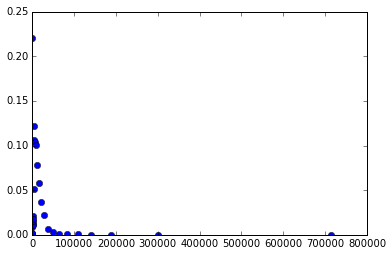

In [403]:
from scipy.optimize import least_squares

for i in range(nrows):
    ax = axs[i,0]
    ax.locator_params(nbins=4)
    tp = time_periods[i]
    data = result_linear_pdf.loc[tp].iloc[:23]
    
    x = data[('mean', 'value')].values
#     y = np.log10(1 - data[('CDF', 'value')].values)
    y = data[('PDF', 'value')].values
#     yerr = np.log10(1 - data[('CDF', 'value')].values) - np.log10(1 - data[('CDF', 'value')].values - data[('CDF', 'std')].values/2.)
    valid_mask = (y > -np.inf) & (x > -np.inf)
    
    x0 = np.ones(3)
    res_lsq = least_squares(lsq, x0, args=(x[valid_mask], y[valid_mask]))
    res_robust = least_squares(lsq, x0, loss='soft_l1', f_scale=0.1, args=(x[valid_mask], y[valid_mask]))
#     res_robust = least_squares(fun, x0, loss='soft_l1', f_scale=0.1, args=(t_train, y_train))

    
    data = result_linear_pdf.loc[tp]
    x_test = data[('mean', 'value')].values
    y_test = data[('PDF', 'value')].values
    y_lsq = formula(x_test, *res_lsq.x)
    y_robust = formula(x_test, *res_robust.x)
    plt.plot(x_test, y_test, 'o', label='data')
    plt.plot(x_test, y_lsq, label='true')
    plt.plot(x_test, y_robust, label='true')
    plt.xlabel('$t$')
    plt.ylabel('$y$')
    plt.xscale('log')
    plt.yscale('log')
#     plt.legend();
    
#     z = np.polyfit(x[valid_mask], y[valid_mask], 1, w = 1/yerr[valid_mask], full = False, cov = True)
#     print z
#     print 'Pareto alpha: '+str(-z[0][0])
#     xm = np.power(10, -z[0][1]/z[0][0])
#     xm_err = np.power(10, -(z[0][1] + z[1][1, 1])/z[0][0]) - xm
#     print 'Xm: '+str(round(xm, -2))
#     print 'Xm_err: '+str(round(xm_err, -2))
#     xp = np.linspace(4, 6, 10)
#     p = np.poly1d(z[0])

#     _ = plt.plot(x, y, '.', xp, p(xp), '-', xp)
#     plt.xlim(4,6)|
#     plt.ylim(-5,0)
#     plt.show()

(1, 20)

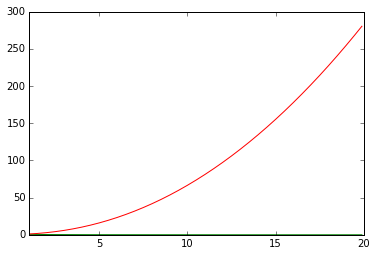

In [413]:
def formula(x, p0, p1, p2):
    p = (p0, p1, p2)
    num1 = np.power(x / p[1], p[0])
    num2 = (np.sqrt(1 + (p[2]*np.power(x / p[1], p[0]))**2) - p[2] * np.power(x / p[1], p[0]))
    denominator = (np.sqrt(1 + (p[2]*np.power(x / p[1], p[0]))**2) * (x / p[0]))
    return num1, num2, denominator

x_ = np.arange(0, 20, .1)

num1, num2, den = formula(x_, 1.1, 1.5, .9)

plt.plot(x_test, y_test, 'o', label='data')
# plt.plot(x_, num1, label='true')
plt.plot(x_, num2, label='true')
plt.plot(x_, den, label='true')
plt.xlim(1, 20)
# plt.xscale('log')
# plt.yscale('log')

ValueError: x and y must have same first dimension

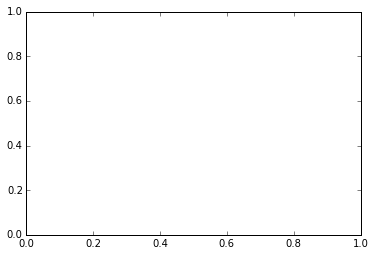

In [401]:
plt.plot(np.arange(0, 1, .1), num2, label='true')
# np.arange(0, 1, .1)

In [10]:
# Distribution in the upper tail 
indiv = indiv.loc[indiv.CH06 >= 18]
df = indiv[['P47T']]

# df['x1']
# df['pdf']
# df['x2']
# df['cdf']



# P = 1 - df.rank(pct = True)
# df['log_top_perc'] = -np.log10(P)
# df['log_G'] = np.log10(df[['P47T']]) #gross income
# A = 9.6e+03;a = -0.37040834;B = 0;b = -0.09;
# df['model'] = np.log10((A * np.power(P, a) + B * np.power(P, b))*(1 - P))
# df_ = df.replace([-np.inf, np.inf], np.nan).dropna().sort_values(by = 'log_top_perc')

# fig, ax = plt.subplots(1, figsize = (8, 6))
# df_.plot(marker = '.', x = 'log_top_perc', y = 'log_G', mec = 'None', ax = ax)
# df_.plot(marker = '.', x = 'log_top_perc', y = 'model', mec = 'None', ax = ax)
# ax.set_xlim(0, 5)
# plt.show()

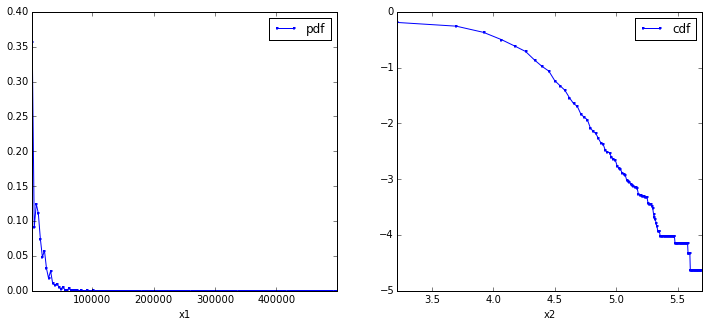

In [49]:
df1 = pd.DataFrame([])
hist = np.histogram(df.dropna(), 150)
df1['pdf'] = hist[0]/float(sum(hist[0]))
df1['x1'] = (hist[1][:-1] + hist[1][1:])/2.
df1['cdf'] = np.log10(1 - np.cumsum(df1['pdf']))
df1['x2'] = np.log10(df1['x1'])

fig, axs = plt.subplots(1, 2, figsize = (12, 5))
ax = axs[0]
df1.plot(marker = '.', x = 'x1', y = 'pdf', mec = 'None', ax = ax)
ax = axs[1]
df1.plot(marker = '.', x = 'x2', y = 'cdf', mec = 'None', ax = ax)
# ax.set_xlim(0, 5)
plt.show()

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

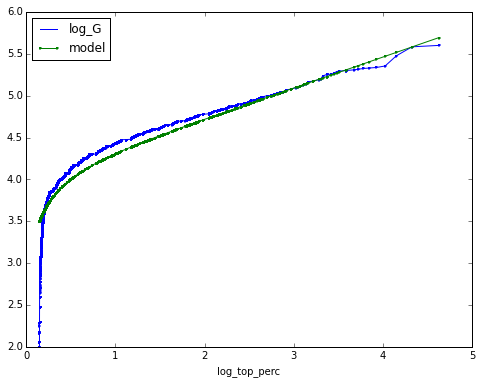

In [8]:
# Distribution in the upper tail 
indiv = indiv.loc[indiv.CH06 >= 18]
df = indiv[['P47T']]
P = 1 - df.rank(pct = True)
df['log_top_perc'] = -np.log10(P)
df['log_G'] = np.log10(df[['P47T']]) #gross income
A = 9.6e+03;a = -0.37040834;B = 0;b = -0.09;
df['model'] = np.log10((A * np.power(P, a) + B * np.power(P, b))*(1 - P))
df_ = df.replace([-np.inf, np.inf], np.nan).dropna().sort_values(by = 'log_top_perc')

fig, ax = plt.subplots(1, figsize = (8, 6))
df_.plot(marker = '.', x = 'log_top_perc', y = 'log_G', mec = 'None', ax = ax)
df_.plot(marker = '.', x = 'log_top_perc', y = 'model', mec = 'None', ax = ax)
ax.set_xlim(0, 5)
plt.show()

In [231]:
from scipy import optimize

df_sample = df_#.sample(20)

# optimize.curve_fit(func_2, df_sample['log_top_perc'], df_sample['P47T'], p0=(13000, -0.32, 100, -0.1))
optimize.curve_fit(func, df_sample['log_top_perc'], df_sample['log_G'], p0=(13000, -0.32))


(array([  1.30000000e+04,  -3.20000000e-01]), array([[ inf,  inf],
        [ inf,  inf]]))

In [227]:
def func(x, A, a):
    return np.log10(A * np.power(x, a)*(1 - x))
#     return A * np.power(x, a)*(1 - x)

def func_2(x, A, a, B, b):
#     return np.log10((A * np.power(x, a) + B * np.power(x, b))*(1 - x))
    return (A * np.power(x, a) + B * np.power(x, b))*(1 - x)

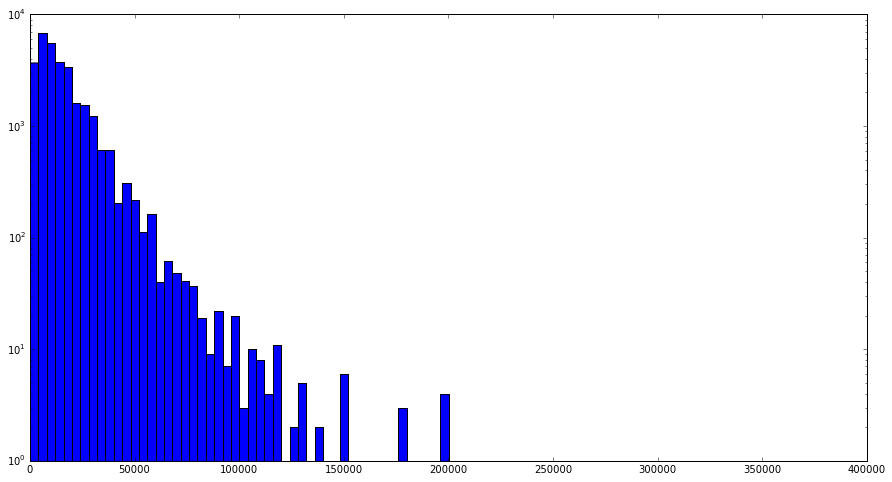

In [187]:
# population distribution

plt.figure(figsize = (15, 8))
# plt.hist((hogar['ITF']/hogar['IX_TOT']).values, 60)
plt.hist((df_['P47T']).values, 100)
plt.yscale('log')
# plt.xscale('log')
plt.show()

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [175]:
df_['bins'] = pd.cut(df_['log_G'], 25)
df_.groupby('bins')['P47T'].sum()


bins
(1.841, 1.995]          140.0
(1.995, 2.146]         1220.0
(2.146, 2.296]         1456.0
(2.296, 2.446]         2650.0
(2.446, 2.596]         3900.0
(2.596, 2.747]        30530.0
(2.747, 2.897]       169300.0
(2.897, 3.047]       439078.0
(3.047, 3.198]       536490.0
(3.198, 3.348]      1162908.0
(3.348, 3.498]      2473513.0
(3.498, 3.648]      4469437.0
(3.648, 3.799]     13817621.0
(3.799, 3.949]     33580101.0
(3.949, 4.099]     55529173.0
(4.099, 4.25]      62569607.0
(4.25, 4.4]       105129899.0
(4.4, 4.55]        78100760.0
(4.55, 4.7]        58463992.0
(4.7, 4.851]       26727692.0
(4.851, 5.001]     13623350.0
(5.001, 5.151]      5330500.0
(5.151, 5.302]      3576000.0
(5.302, 5.452]      1283900.0
(5.452, 5.602]      1084750.0
Name: P47T, dtype: float64

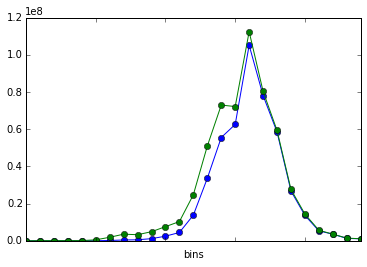

In [173]:
df_.groupby('bins')['P47T'].sum().plot(marker = 'o')
df_['model_summable'] = np.power(10, df_['model'])
df_.groupby('bins')['model_summable'].sum().plot(marker = 'o')

In [182]:
# full distribution based on model
dg = pd.DataFrame(np.arange(2, 7, .1), columns = ['log_G'])
P = np.power(10, -dg['log_G'])
dg['model'] = np.log10((A * np.power(P, a) + B * np.power(P, b))*(1 - P))
dg

,log_G,model
0,2.0,4.749579
1,2.1,4.782480
2,2.2,4.815194
3,2.3,4.847761
4,2.4,4.880211
5,2.5,4.912568
6,2.6,4.944851
7,2.7,4.977076
8,2.8,5.009254
9,2.9,5.041396
